# Playground Series Season 3 Episode 1

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# input the dataset
df_train = pd.read_csv('/kaggle/input/playground-series-s3e1/train.csv', index_col=0)
df_test = pd.read_csv('/kaggle/input/playground-series-s3e1/test.csv', index_col=0)

## 1) Data exploration & preparation

In [3]:
df_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
id,,,,,,,,,
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [4]:
# the number of rows (observations) and columns (features)
df_train.shape

(37137, 9)

The dataset contains **37137** rows and **10** features including the *id* and the target variable which is **MedHouseVal**.

**Combine the training and the test set to do some data preprocessing**

In [5]:
# combine train and test sets
y = df_train.pop('MedHouseVal')
df = df_train.append(df_test)

---

In [6]:
# Missing values
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

No missing values in the dataset.

#### Handling outliers (Extreme values)

We use IQR approach to handle outliers

In [7]:
df_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329
std,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028
min,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000
25%,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000
50%,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000
75%,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000
max,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000


From the above chart, we can see that *Population* and *AveOccup* features contain some outliers which will be taken care of later.<br>
Consider the figure bellow to visualize better the outliers.

Text(0.5, 1.0, 'Population')

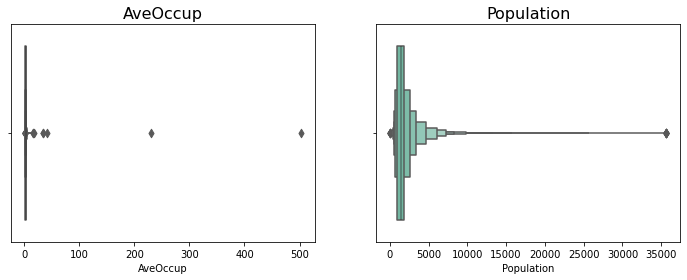

In [8]:
# Average Occupant
plt.figure(figsize=(12, 4))
sns.set_palette('Set2')

plt.subplot(1, 2, 1)
ax = sns.boxenplot(x=df['AveOccup'])
ax.set_title('AveOccup', fontdict={'fontsize':16})

# population
plt.subplot(1, 2, 2)
ax = sns.boxenplot(x=df['Population'])
ax.set_title('Population', fontdict={'fontsize':16})

Well, lets apply *IQR* to handle the outliers. In this case, we will replace them by their mean values.

In [9]:
# the function to replace outliers with nan
def replace_outliers_with_nan_iqr(df, feature, inplace=False):
    desired_feature = df[feature]
    
    q1, q3 = desired_feature.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    indices = (desired_feature[(desired_feature > upper_bound) | (desired_feature < lower_bound)]).index
    if not inplace:
        return desired_feature.replace(desired_feature[indices].values, np.nan)
    return desired_feature.replace(desired_feature[indices].values, np.nan, inplace=True)

Replace outliers by NaN in 'Population' and 'AveOccup' features

In [10]:
# replace outliers by NaN in 'Population' and 'AveOccup' features
replace_outliers_with_nan_iqr(df, 'Population', inplace=True)
replace_outliers_with_nan_iqr(df, 'AveOccup', inplace=True)

In [11]:
# number of values replaced by Nan
df['Population'].isnull().sum()

4236

In [12]:
# number of values replaced by Nan
df['AveOccup'].isnull().sum()

2338

In [13]:
# replace the NaN values of 'Population' and 'AveOccup' features with their mean values
df['Population'].fillna(value=df['Population'].mean(), inplace=True)
df['AveOccup'].fillna(value=df['AveOccup'].mean(), inplace=True)

---

## 2) Modeling

Now, we will separate back the training and the test sets from each other.

In [14]:
df_train = df.iloc[:df_train.shape[0]]
df_test = df.iloc[df_train.shape[0]:]

In [15]:
df_train.shape

(37137, 8)

In [16]:
# split the trian and val data
from sklearn.model_selection import train_test_split

X = df_train
y = y

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)

In [17]:
# fit the dataset to the model
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [18]:
# make a prediction
y_pred = model.predict(X_val)

In [19]:
# Check the accuracy of the model
# RMSE
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_val, y_pred, squared=False)
print('RMSE: ', rmse)

RMSE:  0.5754103768815384


# Prediction on the test set and submission

In [20]:
preds = model.predict(df_test)

In [21]:
submission = pd.DataFrame({
    'id': df_test.index,
    'MedHouseVal': preds
})

In [22]:
submission.to_csv('./submission.csv', index=False)

# Thank you :)